In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
#%matplotlib widget

# PyTorch for System Identification


Adapted from [this tutorial](https://github.com/dariopi/Deep_Learning_for_SYSID_Lugano24/blob/main/Lessons/PyTorch_intro/PyTorch_for_System_Identification.ipynb]) from Gabriele Maroni (SUPSI-IDSIA).


## NARX and RNN modeling

We look at the implementation of two kinds of models:

* NARX (SISO case):
$$y(k) = \mathcal{F}(\overbrace{y(k-1), \dots, y(k-n_a), u(k - n_k), \dots, u(k - n_b -n_k +1)}^{=\phi(k)};\; W)$$
   - $n_a$: number of autoregressive coefficients
   - $n_b$: number of past input coefficients
   - $n_k$: number of input delays. If $n_k = 0$, we allow an instantaneous input/output response)
   - $\mathcal{F}: \mathbb{R}^{n_\phi} \rightarrow \mathbb{R}^{n_y}$ function with learnable parameters $W$. The regressor $\phi$ has dimension $n_\phi = n_a n_y + n_b n_u$. 

* RNN, aka state-space (MIMO case):
\begin{align*}
h(k) &= f(h(k-1), u(k);\; W_f) \\
y(k) &= g(h(k), u(k);\; W_g)
\end{align*}

* $h \in \mathbb{R}^{n_h}$: hidden of latent state. System state $x$ in system theory!
* $f: \mathbb{R}^{n_h \times n_u} \rightarrow \mathbb{R}^{n_h}$: state-update functio with learnable parameters $W_f$
* $g: \mathbb{R}^{n_h \times n_u} \rightarrow \mathbb{R}^{n_y}$  output function with parameters $W_g$.

From the practicioner's perspective, most of the differences are in the data preparation.

* For NARX:

    *   a training instance is: $\big( \phi(k) \in \mathbb{R}^{n_\phi}, \;\; y(k) \in \mathbb{R}^{n_y}\big).$
    *   a training batch of $B$ element is a pair with dimensions $(B, n_\phi), (B, n_y)$.

  
* For RNN:
    * a training instance is: $\bigg( \big[u(0), \dots u(T-1)] \in \mathbb{R}^{T \times n_u}, \;\; [y(1), \dots y(T-1)\big] \in \mathbb{R}^{l \times n_u} \bigg) $, i.e. an input/output sequence of length $T$.
    * a training batch of $B$ elements is a pair with dimensions $(B, T, n_u), (B, T, n_y)$.
    * an initial state $h(0)$ for each training sequence may also be specified.

## Load dataset

The available dataset consist in a single input/output sequence. The following dataset is generated by a (simulated) non-linear mass-spring-damper.

Mass-spring-damped   |  Spring characteristics
:-------------------------:|:-------------------------:
![](images/MSD.png)  |  ![](images/spring.png)

Non-linear spring characteristics:
$$
f(x) = k x + \alpha x^3, \quad \alpha > 0 \quad \text{(hardening spring)}
$$
System is described by: 
$$
F - c\dot{x} - k x - \alpha x^3 = m\ddot{x}
$$
Rearranging we get:
$$
\ddot{x} = \frac{1}{m}(F - c\dot{x} - k x - \alpha x^3)
$$
Setting $x=x_1$, $\dot{x} = x_2$, $F=u$, and $y = x$ we can write the system in standard state-space form:
        
\begin{align*}
    \dot{x_1} &= x_2 \\
    \dot{x_2} &= \frac{1}{m}(u - c x_2 - k x_1 - \alpha x^3_1) \\
    y &= x.
\end{align*}

However, in the following we assume no physical knowledge and learn black-box model for this system from data.

In [3]:
# Dataset path
dataset_folder = os.path.join("..", "..", "..", "data", "MassSpringDamper")
dataset_name = "mass_spring_damper_nonlinear.csv"

In [4]:
dataset_path = os.path.join(dataset_folder, dataset_name)
df = pd.read_csv(dataset_path)
df.shape

(20000, 3)

In [5]:
df.head()

,t,u,y
0,0.0,0.000000,40.037819
1,0.5,1.538924,39.649408
2,1.0,2.258279,39.442578
3,1.5,2.931616,39.053522
4,2.0,2.161179,38.411349


In [6]:
nu = 1 
ny = 1

## Data visualization

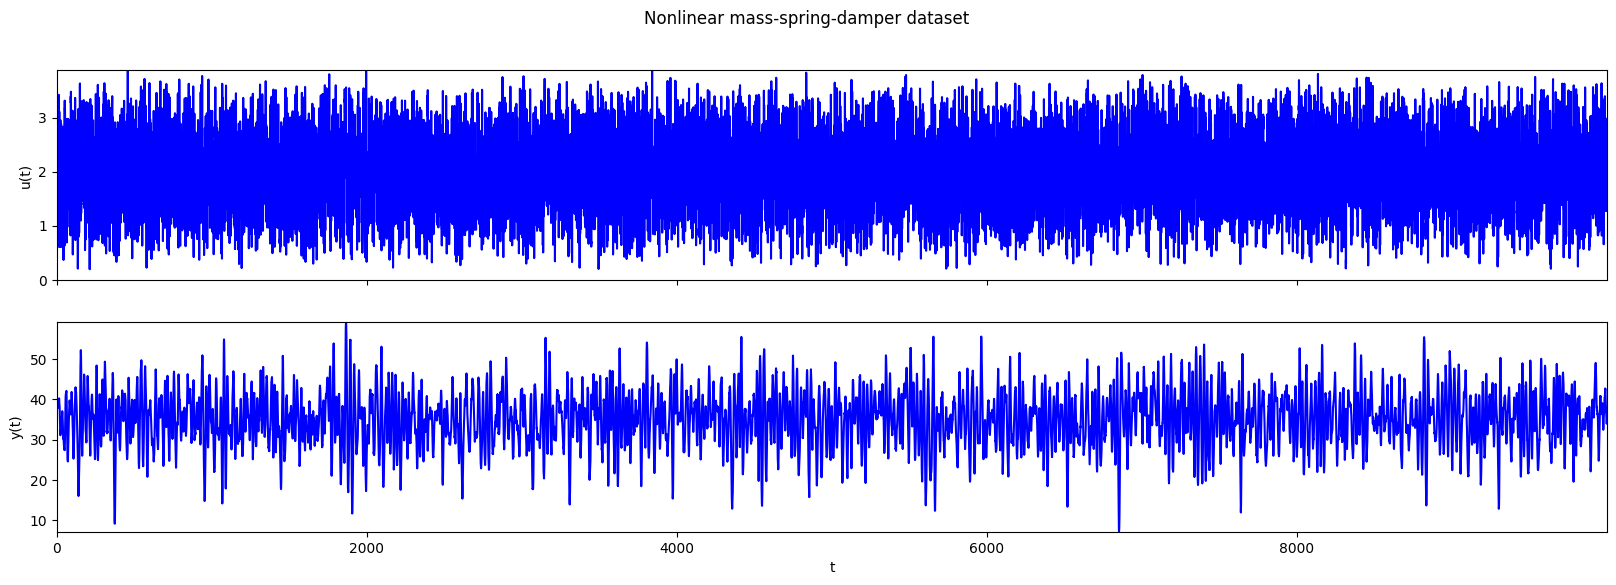

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(20, 6), sharex=True)
fig.suptitle("Nonlinear mass-spring-damper dataset")
ax[0].plot(df["t"], df["u"], "b")
ax[0].set_ylabel("u(t)")
ax[0].margins(0.0)

ax[1].plot(df["t"], df["y"], color="b")
ax[1].set_ylabel("y(t)")
ax[1].set_xlabel("t")
ax[1].margins(0.0)

#ax[1].set_xlim([2000, 2100])
plt.show()

## Train / Test split

For sequential data, it makes sense to split datasets without random shuffling that would destroy the causal temporal dependencies

In [8]:
N = len(df)
df_train = df.iloc[: int(0.8 * N)]
df_test = df.iloc[int(0.8 * N) :]
df_train.shape, df_test.shape

((16000, 3), (4000, 3))

In [9]:
# same as above, with sklearn
# from sklearn.model_selection import train_test_split
# df_train, df_test = train_test_split(df, test_size=0.2, shuffle=False)
# df_train.shape, df_test.shape

## Normalization

Always normalize training and test datasets based on the training statistics.

In [10]:
# Normalization
df_mean = df_train.mean()
df_std = df_train.std()
df_train_sc = (df_train - df_mean) / df_std
df_test_sc = (df_test - df_mean) / df_std

df_test_sc.head()

,t,u,y
16000,1.732105,0.321856,-1.276035
16001,1.732321,0.254382,-1.155519
16002,1.732538,-0.690165,-1.095082
16003,1.732754,-1.563026,-1.002191
16004,1.732971,-2.124065,-0.932540


## (N)ARX modeling

In [11]:
na = 2
nb = 3
nk = 0

In [12]:
n = np.max((na, nb+nk-1)) # maximum lag
nphi = na + nb # number of trainable parameters

For NARX modeling, we need to create training instances in the form:

$$\bigg (\overbrace{y(k-1), \dots, y(k-n_a), u(k - n_k), \dots, u(k - n_b -n_k +1))}^{=\phi(k)}, \;\;y(k) \bigg)$$

Our dataset is not in this form. There are many  ways to fix this. One is to use dataframes' ``.shift`` method.

In [13]:
df_train_shift = df_train.shift(1)  # whole dataset shifted by 1 step

In [14]:
df_train_shift.head()

,t,u,y
0,NaN,NaN,NaN
1,0.0,0.000000,40.037819
2,0.5,1.538924,39.649408
3,1.0,2.258279,39.442578
4,1.5,2.931616,39.053522


In [15]:
df_train.head()

,t,u,y
0,0.0,0.000000,40.037819
1,0.5,1.538924,39.649408
2,1.0,2.258279,39.442578
3,1.5,2.931616,39.053522
4,2.0,2.161179,38.411349


In [16]:
def build_narx_dataset(df, na, nb, nk, dropna=True):

    # include time and target variable y(k)
    dict_narx = {"t": df["t"].copy(), "y(k)": df["y"].copy()}
    target = ["y(k)"]
    regressor = []

    # add lagged output variables y(k-1), ... y(k-na)
    for tau_a in range(1, na + 1):
        lagged_name = f"y(k-{tau_a})"
        dict_narx[lagged_name] = df["y"].shift(tau_a)
        regressor.append(lagged_name)

    # add lagged input variables u(k-n_k), ... u(k-nb-n_k+1)
    for tau_b in range(nk, nb + nk):
        lagged_name = f"u(k-{tau_b})" if tau_b != 0 else "u(k)"
        dict_narx[lagged_name] = df["u"].shift(tau_b)
        regressor.append(lagged_name)

    df_narx = pd.DataFrame(dict_narx)
    if dropna:
        df_narx.dropna(inplace=True)
        # df_narx.reset_index(inplace=True, drop=True)

    return df_narx, regressor, target

In [17]:
df_train_arx, regressor, target = build_narx_dataset(df_train_sc, na, nb, nk)
df_test_arx, _, _ = build_narx_dataset(df_test_sc, na, nb, nk)
df_train_arx.head()

,t,y(k),y(k-1),y(k-2),u(k),u(k-1),u(k-2)
2,-1.731455,0.621491,0.650908,0.706149,0.372542,-0.645100,-2.822151
3,-1.731239,0.566158,0.621491,0.650908,1.325084,0.372542,-0.645100
4,-1.731022,0.474825,0.566158,0.621491,0.235178,1.325084,0.372542
5,-1.730806,0.448566,0.474825,0.566158,-0.174321,0.235178,1.325084
6,-1.730589,0.435105,0.448566,0.474825,1.511087,-0.174321,0.235178


In [18]:
regressor, target

(['y(k-1)', 'y(k-2)', 'u(k)', 'u(k-1)', 'u(k-2)'], ['y(k)'])

Note that there are different ways to assemble the regression matrix. Mathematically inclined people may like to exploit the properties of Toeplitz matrices...

In [19]:
# build the matrix with regressors y(k), y(k-1), ... y(k-na)
# import scipy
#scipy.linalg.toeplitz(c=df_train_sc["y"].iloc[na:],
#                     r=np.flip(df_train_sc["y"].values[:na+1])
#                   )

A manual for loop also does the job:

In [20]:
#y_past = np.zeros(df_train_sc.shape[0] - na, n_a + 1)
#for idx in range(df_train_sc.shape[0]):
#    ... # index headache 

### Linear modeling (ARX)

In [21]:
# Model fitting
arx = sklearn.linear_model.LinearRegression(fit_intercept=False)
arx.fit(df_train_arx[regressor], df_train_arx[target].values)

LinearRegression(fit_intercept=False)

In [22]:
# Retrieve learned coefficients
arx.coef_

array([[ 1.87564782, -0.89259616,  0.00444233,  0.01572546,  0.00696755]])

#### Performance evaluation

Let us first define some metrics. We actually use the ones in scikit-learn.

In [23]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    root_mean_squared_error,
)

# defined here once and used throughout the notebook
def regression_metrics(y_true, y_pred):
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "rmse": root_mean_squared_error(y_true, y_pred),
        "r2": r2_score(y_true, y_pred),
    }

One-step ahead prediction performance

In [24]:
# Train prediction
y_pred_train = arx.predict(df_train_arx[regressor]) # normalized prediction
y_pred_train = y_pred_train * df_std["y"] + df_mean["y"]  # unnormalize

# Test prediction
y_pred_test = arx.predict(df_test_arx[regressor])
y_pred_test = y_pred_test * df_std["y"] + df_mean["y"]

In [25]:
# Compute evaluation metrics on train
regression_metrics(df_train["y"].iloc[n:], y_pred_train)

{'mse': 0.08363086964667764,
 'mae': 0.23052970688278446,
 'rmse': 0.2891900234217592,
 'r2': 0.9983083237083157}

In [26]:
# Compute evaluation metrics on test
#regression_metrics(df_test[target], y_pred_test)
regression_metrics(df_test["y"].iloc[n:], y_pred_test)

{'mse': 0.08411788672785049,
 'mae': 0.23122206405858237,
 'rmse': 0.2900308375463728,
 'r2': 0.9981631524803778}

#### Simulation performance

We need some custom code to use the trained NARX model as a simulator, using *predicted* output values instead of measured past values

In [27]:
# Simulate the model on test data
y_sim_test_linear = np.zeros((df_test.shape[0],))
for k in range(n, df_test.shape[0]):
    reg_y = np.flip(y_sim_test_linear[k - na : k]) # \hat y[k-1], ..., \hat y[k-na]
    reg_u = np.flip(df_test_sc["u"].values[k - nb - nk + 1 : k - nk + 1]) # u[k-nb-nk, ..., u[k-nb-nk+1]
    phi_t = np.concatenate((reg_y, reg_u))
    y_sim_test_linear[k] = arx.coef_[0] @ phi_t

y_sim_test_linear = y_sim_test_linear * df_std["y"] + df_mean["y"]

In [28]:
# Compute evaluation metrics on test
regression_metrics(df_test["y"], y_sim_test_linear)

{'mse': 8.137453597168134,
 'mae': 2.30463040485506,
 'rmse': 2.8526222317664383,
 'r2': 0.8223722431119127}

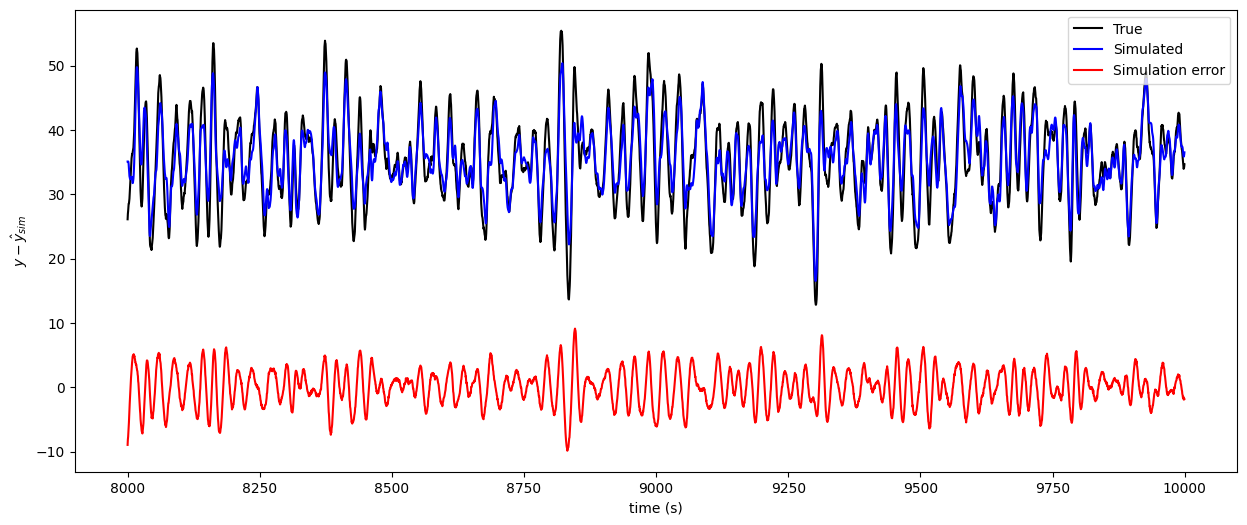

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(df_test["t"], df_test["y"], label="True", color="k")
ax.plot(df_test["t"], y_sim_test_linear, label="Simulated", color="b", linestyle="-")
ax.set_ylabel(r"$y$")
ax.legend()

ax.plot(df_test["t"], df_test["y"].values - y_sim_test_linear, label="Simulation error", color="r")
ax.set_ylabel(r"$y - \hat{y}_{sim}$")
ax.set_xlabel("time (s)")
ax.legend()
plt.show()

## NARX modeling with Feed Forward Neural Networks

In [30]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchsummary import summary

In [31]:
torch.manual_seed(42);

In [32]:
batch_size = 128
hidden_sizes = [20, 10]

In [33]:
# Conversion to PyTorch tensors
x_train = torch.from_numpy(df_train_arx[regressor].values).type(torch.Tensor)
x_test = torch.from_numpy(df_test_arx[regressor].values).type(torch.Tensor)
y_train = torch.from_numpy(df_train_arx[target].values).type(torch.Tensor)
y_test = torch.from_numpy(df_test_arx[target].values).type(torch.Tensor)

In [34]:
x_train.shape, y_train.shape # we will actually train on batches of size (batch_size, 5) -> (batch_size, 1)

(torch.Size([15998, 5]), torch.Size([15998, 1]))

In [35]:
class FeedForwardNN(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(FeedForwardNN, self).__init__()
        layers = []
        # Adding the first hidden layer that connects the input layer to the first hidden layer
        layers.append(nn.Linear(input_size, hidden_sizes[0]))
        layers.append(nn.ReLU())

        # Creating subsequent hidden layers
        for i in range(1, len(hidden_sizes)):
            layers.append(nn.Linear(hidden_sizes[i - 1], hidden_sizes[i]))
            layers.append(nn.ReLU())

        # Adding the output layer
        layers.append(nn.Linear(hidden_sizes[-1], output_size))
        # Wrap all layers in ModuleList so they are properly registered.
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

In [36]:
# Instantiate the model
narx = FeedForwardNN(
    input_size=nphi, hidden_sizes=hidden_sizes, output_size=ny
)

In [37]:
params_arx = sum(p.numel() for p in narx.parameters() if p.requires_grad)
print(f"Total number of trainable model parameters: {params_arx}")

Total number of trainable model parameters: 341


#### NARX model usage

In [38]:
narx(torch.randn(nphi)).shape # single prediction, output size ny

torch.Size([1])

In [39]:
narx(torch.randn(batch_size, nphi)).shape # batched prediction, output size (batch_size, ny) 

torch.Size([128, 1])

In [40]:
#! pip install torchsummary
summary(narx, input_size=(batch_size, len(regressor)), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1              [-1, 128, 20]             120
              ReLU-2              [-1, 128, 20]               0
            Linear-3              [-1, 128, 10]             210
              ReLU-4              [-1, 128, 10]               0
            Linear-5               [-1, 128, 1]              11
Total params: 341
Trainable params: 341
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


In [41]:
# equivalent to the built-in TensorDataset
class RegressionDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [42]:
# Datasets
train_ds = TensorDataset(x_train, y_train) # or RegressionDataset(x_train, y_train)
test_ds = TensorDataset(x_test, y_test)

# Dataloaders
train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, drop_last=True
)
test_dl = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, drop_last=False
)

### Training set-up

In [43]:
import torch.optim as optim

# Define the optimizer
optimizer = optim.Adam(narx.parameters(), lr=1e-4)

# Define loss function
loss_function = nn.MSELoss()

# Calculate loss value with untrained model to use as reference
y_pred_train = narx(x_train)
loss0 = loss_function(y_pred_train, y_train).item()
print(f"Initial loss: {loss0:.5f}")

Initial loss: 1.04427


### Training loop

In [44]:
# Number of epochs
epochs = 1000

# Training loop
for epoch in range(epochs):
    # Training
    loss_epoch = 0.0
    for x_train_batch, y_train_batch in train_dl:
        optimizer.zero_grad()
        y_pred_train_batch = narx(x_train_batch)
        loss = loss_function(y_pred_train_batch, y_train_batch)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item() * x_train_batch.size(0)

    # Average epoch loss (computed just for statistics)
    loss_epoch /= len(train_ds)

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}" f" | Train Loss: {loss_epoch:.6f}")

Epoch: 000/1000 | Train Loss: 1.006919
Epoch: 100/1000 | Train Loss: 0.002680
Epoch: 200/1000 | Train Loss: 0.001734
Epoch: 300/1000 | Train Loss: 0.001701
Epoch: 400/1000 | Train Loss: 0.001691
Epoch: 500/1000 | Train Loss: 0.001685
Epoch: 600/1000 | Train Loss: 0.001681
Epoch: 700/1000 | Train Loss: 0.001677
Epoch: 800/1000 | Train Loss: 0.001677
Epoch: 900/1000 | Train Loss: 0.001676


### Predicting and computing evaluation metrics

#### One-step ahead prediction performance

In [45]:
with torch.no_grad():
    # Train prediction
    y_pred_train = narx(x_train)
    # Test prediction
    y_pred_test = narx(x_test)

# Invert scaling operation
y_pred_train = y_pred_train.numpy() * df_std["y"] + df_mean["y"]
y_pred_test = y_pred_test.numpy() * df_std["y"] + df_mean["y"]

In [46]:
# Compute evaluation metrics on train
regression_metrics(df_train["y"].iloc[n:], y_pred_train)

{'mse': 0.0837241206308015,
 'mae': 0.23048090001308888,
 'rmse': 0.28935120637523093,
 'r2': 0.9983064374373767}

In [47]:
# Compute evaluation metrics on test
regression_metrics(df_test["y"].iloc[n:], y_pred_test)

{'mse': 0.08552814048232915,
 'mae': 0.2332012705696051,
 'rmse': 0.2924519455950484,
 'r2': 0.9981323573521153}

#### Simulation performance

In [48]:
# Simulate the model on test data
y_sim_test_narx = np.zeros((df_test.shape[0],))
for k in range(n, df_test.shape[0]):
    reg_y = np.flip(y_sim_test_narx[k - na : k]) # \hat y[k-1], ..., \hat y[k-na]
    reg_u = np.flip(df_test_sc["u"].values[k - nb - nk + 1 : k - nk + 1]) # u[k-nb-nk, ..., u[k-nb-nk+1]
    phi_t = np.concatenate((reg_y, reg_u))
    phi_t = torch.as_tensor(phi_t).type(torch.float32)
    with torch.no_grad():
        y_sim_test_narx[k] = narx(phi_t).numpy().squeeze()

y_sim_test_narx = y_sim_test_narx * df_std["y"] + df_mean["y"] # unnormalize

In [49]:
# Compute evaluation metrics on test
regression_metrics(df_test["y"], y_sim_test_narx)

{'mse': 11.13213016945634,
 'mae': 2.6290024615480045,
 'rmse': 3.3364847024160533,
 'r2': 0.7570031843776207}

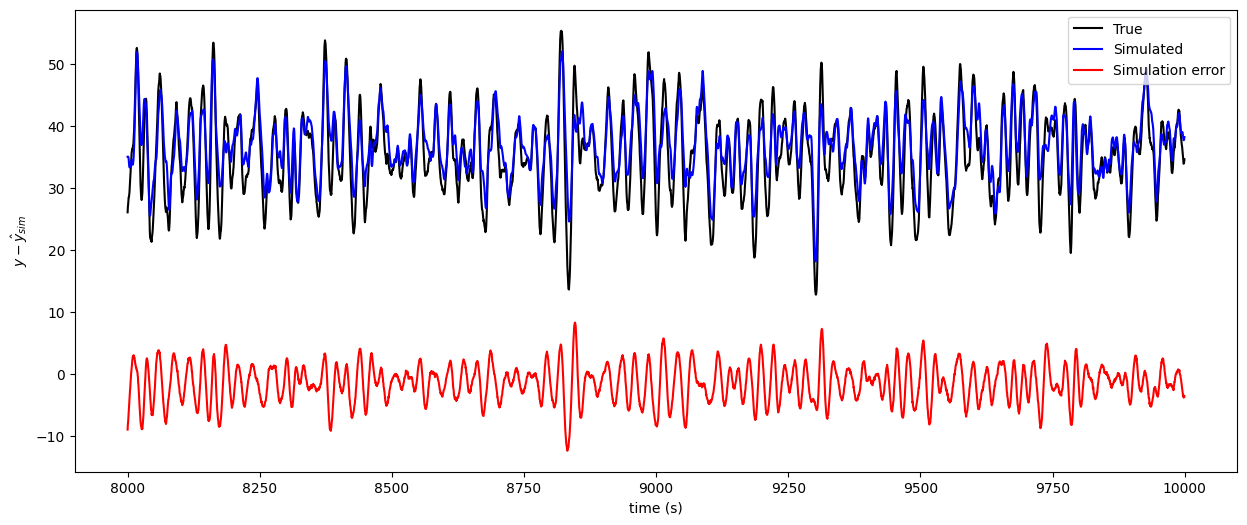

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(df_test["t"], df_test["y"], label="True", color="k")
ax.plot(df_test["t"], y_sim_test_narx, label="Simulated", color="b", linestyle="-")
ax.set_ylabel(r"$y$")
ax.legend()

ax.plot(df_test["t"], df_test["y"].values - y_sim_test_narx, label="Simulation error", color="r")
ax.set_ylabel(r"$y - \hat{y}_{sim}$")
ax.set_xlabel("time (s)")
ax.legend()
plt.show()

## Vanilla RNN modeling

For RNN modeling, we need to create training instances in the form:

  \begin{equation*}
  \bigg ( [u(0), \dots u(T-1)] \in \mathbb{R}^{T \times n_u},\;\; [y(1), \dots y(T-1)] \in \mathbb{R}^{T \times n_u}\bigg ),
  \end{equation*}

where $T$ is the sequence length. The sequence length $T$ is not necessariliy equivalent to the full training sequence lenght. In fact, we typically train over shorter (possibly overlapping) **subsequences**.

Here, we do not instantiate the subsequences explicitly. Rather, we generate them on-the-fly using within a custom PyTorch ``Dataset``.

In [51]:
seq_len = 100 # training sub-sequence length (T above)

In [52]:
df_train.shape # chosen seq_len much shorter than training dataset length

(16000, 3)

In [53]:
class SequenceDataset(Dataset):
    r"""A dataset returning sub-sequences extracted from longer sequences.
        For simplicity, this version does not support overlapping subsequences.
    Args:
        *tensors (Tensor): tensors that have the same size on the first dimension.
        seq_len (int): length of the subsequences to extract.
    Examples:
        >>> u = torch.randn(1000, 2) # 2 inputs
        >>> y = torch.randn(1000, 3) # 3 outputs
        >>> train_dataset = SequenceDataset(u, y, seq_len=100)
    """

    def __init__(self, *tensors, seq_len):
        self.tensors = tensors

        self.seq_len = seq_len
        assert all(tensor.shape[0] == self.tensors[0].shape[0] for tensor in self.tensors), "All tensors must have the same length"
        self.total_len = self.tensors[0].shape[0]

    def __len__(self):
        return int(self.total_len // self.seq_len)

    def __getitem__(self, idx):
        start = idx * self.seq_len
        stop = start + self.seq_len
        return [tensor[start:stop] for tensor in self.tensors]

#### ``SequenceDataset`` usage

In [54]:
ds = SequenceDataset(torch.arange(12), torch.ones(12), seq_len=3)
len(ds)

4

In [55]:
ds[0]

[tensor([0, 1, 2]), tensor([1., 1., 1.])]

In [56]:
ds[1]

[tensor([3, 4, 5]), tensor([1., 1., 1.])]

In [57]:
# Conversion to PyTorch tensors, add a "feature" channel
u_train = torch.from_numpy(df_train_sc["u"].values).type(torch.Tensor).unsqueeze(1)
u_test = torch.from_numpy(df_test_sc["u"].values).type(torch.Tensor).unsqueeze(1)
y_train = torch.from_numpy(df_train_sc["y"].values).type(torch.Tensor).unsqueeze(1)
y_test = torch.from_numpy(df_test_sc["y"].values).type(torch.Tensor).unsqueeze(1)

In [58]:
u_train.shape, y_train.shape, u_test.shape, y_test.shape

(torch.Size([16000, 1]),
 torch.Size([16000, 1]),
 torch.Size([4000, 1]),
 torch.Size([4000, 1]))

In [59]:
# Datasets
train_ds = SequenceDataset(
    u_train, y_train, seq_len=seq_len
)
test_ds = SequenceDataset(
    u_test, y_test, seq_len=seq_len
)

In [60]:
len(train_ds), len(test_ds)

(160, 40)

In [61]:
# training dataset is so small that we can set the batch size of the same length. This is not always the case!
batch_size = 160 

In [62]:
# Dataloaders
train_dl = DataLoader(
    train_ds, batch_size=batch_size, shuffle=True, drop_last=True
)
test_dl = DataLoader(
    test_ds, batch_size=batch_size, shuffle=False, drop_last=False
)

In [63]:
for batch_u, batch_y in train_dl:
    break

In [64]:
batch_u.shape, batch_y.shape # (batch_size, seq_len, nu), (batch_size, seq_len, ny)

(torch.Size([160, 100, 1]), torch.Size([160, 100, 1]))

### RNN Architecture

We apply a standard Vanilla, aka [Elman RNN](https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html)
complemented with a linear output equation:

\begin{align*}
h(k) &= \tanh(W_{h} h(k-1) + W_u u(k) + b_h) \\
y(k)   &= W_y h(k) + b_y.
\end{align*}

In [65]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # RNN layer, implements the state-update equation f(x)
        self.seq = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer, implements the linear output equation
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, u_seq):

        # Run state-update sequentially for all time steps
        # Compute hidden state sequence.
        # Second argument is initial state, normally omitted (set to None=0)
        # Second return value is the last state, unused here.
        h, _ = self.seq(u_seq, None) 
        
        # Run output function
        y = self.fc(h) # output sequence
        return y

In [66]:
# Instantiate the model
rnn = RNN(
    input_size=u_train.shape[1],
    hidden_size=20,
    output_size=y_train.shape[1],
    num_layers=1,
)

In [67]:
params_rnn = sum(p.numel() for p in rnn.parameters() if p.requires_grad)
print(f"Total number of trainable model parameters: {params_rnn}")

Total number of trainable model parameters: 481


#### RNN model usage

In [68]:
# single sequence usage
rnn(torch.randn(seq_len, nu)).shape # (seq_len, ny)

torch.Size([100, 1])

In [69]:
# batched usage
rnn(torch.randn(batch_size, seq_len, nu)).shape # (batch_size, seq_len, ny)

torch.Size([160, 100, 1])

### Training set-up

In [70]:
# Define the optimizer
optimizer = optim.Adam(rnn.parameters(), lr=1e-4)

# Define loss function
loss_function = nn.MSELoss()

### Training loop

In [71]:
# Number of epochs
epochs = 5000

# Training loop
for epoch in range(epochs):
    # Training
    loss_epoch = 0.0
    for batch_u, y_train_batch in train_dl:
        optimizer.zero_grad()
       
        y_pred_train_batch = rnn(batch_u)  # h0 is initialized to 0. There are better ways to do this, but we  keep it simple for now.
        loss = loss_function(y_pred_train_batch, y_train_batch)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item() * x_train_batch.size(0)

    # Average loss
    loss_epoch /= len(train_ds)

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}" f" | Train Loss: {loss_epoch:.6f}")

Epoch: 000/5000 | Train Loss: 0.935305
Epoch: 100/5000 | Train Loss: 0.860188
Epoch: 200/5000 | Train Loss: 0.808927
Epoch: 300/5000 | Train Loss: 0.761935
Epoch: 400/5000 | Train Loss: 0.592995
Epoch: 500/5000 | Train Loss: 0.536128
Epoch: 600/5000 | Train Loss: 0.482752
Epoch: 700/5000 | Train Loss: 0.391329
Epoch: 800/5000 | Train Loss: 0.344150
Epoch: 900/5000 | Train Loss: 0.316614
Epoch: 1000/5000 | Train Loss: 0.297756
Epoch: 1100/5000 | Train Loss: 0.281522
Epoch: 1200/5000 | Train Loss: 0.266841
Epoch: 1300/5000 | Train Loss: 0.253436
Epoch: 1400/5000 | Train Loss: 0.240825
Epoch: 1500/5000 | Train Loss: 0.227446
Epoch: 1600/5000 | Train Loss: 0.211583
Epoch: 1700/5000 | Train Loss: 0.200242
Epoch: 1800/5000 | Train Loss: 0.196396
Epoch: 1900/5000 | Train Loss: 0.193686
Epoch: 2000/5000 | Train Loss: 0.191300
Epoch: 2100/5000 | Train Loss: 0.189227
Epoch: 2200/5000 | Train Loss: 0.187452
Epoch: 2300/5000 | Train Loss: 0.185934
Epoch: 2400/5000 | Train Loss: 0.184594
Epoch: 250

### Predicting and computing evaluation metrics

#### Simulation performance

In [72]:
u_test.shape # The RNN can also handle single input sequences, size (seq_len, nu)

torch.Size([4000, 1])

In [73]:
with torch.no_grad():
    y_sim_test_rnn = rnn(u_test)
y_sim_test_rnn = y_sim_test_rnn.numpy() * df_std["y"] + df_mean["y"]

In [74]:
y_sim_test_rnn = y_sim_test_rnn[:, 0]

In [75]:
regression_metrics(df_test["y"], y_sim_test_rnn)

{'mse': 0.5839291082731474,
 'mae': 0.4719644682218253,
 'rmse': 0.7641525425418326,
 'r2': 0.9872537500281027}

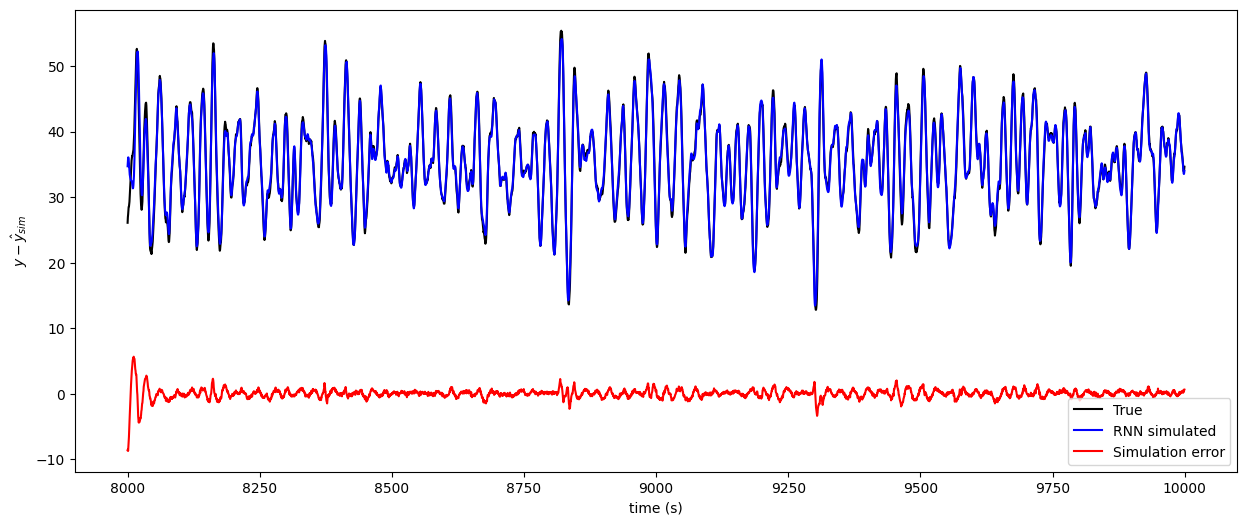

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(df_test["t"], df_test["y"], label="True", color="k")
ax.plot(df_test["t"], y_sim_test_rnn, label="RNN simulated", color="b", linestyle="-")
ax.set_ylabel(r"$y$")
ax.legend()

ax.plot(df_test["t"], df_test["y"].values - y_sim_test_rnn, label="Simulation error", color="r")
ax.set_ylabel(r"$y - \hat{y}_{sim}$")
ax.set_xlabel("time (s)")
ax.legend();

## Modeling: LSTM

From the end-user perspective, the LSTM is just a fancier architecture. Model usage is nearly identical to the vanilla RNN.

In [77]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # Define the LSTM layer
        self.seq = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, u_seq):

        # TODO: handle initial hidden and cell states
        out, _ = self.seq(u_seq) # _ receives (h_n, c_n), unused here

        # Decode the hidden state of the last time step
        y = self.fc(out)
        return y

In [78]:
# Instantiate the model
lstm = LSTM(
    input_size=u_train.shape[1],
    hidden_size=20,
    output_size=y_train.shape[1],
    num_layers=2,
)
params_lstm = sum(p.numel() for p in lstm.parameters() if p.requires_grad)
print(f"Total number of trainable model parameters: {params_lstm}")

# Define the optimizer
optimizer = optim.Adam(lstm.parameters(), lr=1e-3)

# Define loss function
loss_function = nn.MSELoss()

Total number of trainable model parameters: 5221


In [79]:
# Number of epochs
epochs = 5000

# Training loop
for epoch in range(epochs):
    # Training
    loss_epoch = 0.0
    for batch_u, y_train_batch in train_dl:
        optimizer.zero_grad()
        y_pred_train_batch = lstm(batch_u)
        loss = loss_function(y_pred_train_batch, y_train_batch)
        loss.backward()
        optimizer.step()
        loss_epoch += loss.item() * x_train_batch.size(0)

    # Average loss
    loss_epoch /= len(train_ds)

    # Logging
    if epoch % 100 == 0:
        print(f"Epoch: {epoch:03d}/{epochs:03d}" f" | Train Loss: {loss_epoch:.6f}")

Epoch: 000/5000 | Train Loss: 0.808515
Epoch: 100/5000 | Train Loss: 0.380607
Epoch: 200/5000 | Train Loss: 0.188187
Epoch: 300/5000 | Train Loss: 0.178412
Epoch: 400/5000 | Train Loss: 0.175643
Epoch: 500/5000 | Train Loss: 0.174282
Epoch: 600/5000 | Train Loss: 0.174218
Epoch: 700/5000 | Train Loss: 0.172198
Epoch: 800/5000 | Train Loss: 0.171325
Epoch: 900/5000 | Train Loss: 0.170399
Epoch: 1000/5000 | Train Loss: 0.169118
Epoch: 1100/5000 | Train Loss: 0.167704
Epoch: 1200/5000 | Train Loss: 0.167575
Epoch: 1300/5000 | Train Loss: 0.163947
Epoch: 1400/5000 | Train Loss: 0.170951
Epoch: 1500/5000 | Train Loss: 0.159608
Epoch: 1600/5000 | Train Loss: 0.157842
Epoch: 1700/5000 | Train Loss: 0.153952
Epoch: 1800/5000 | Train Loss: 0.146237
Epoch: 1900/5000 | Train Loss: 0.147968
Epoch: 2000/5000 | Train Loss: 0.136860
Epoch: 2100/5000 | Train Loss: 0.132079
Epoch: 2200/5000 | Train Loss: 0.127857
Epoch: 2300/5000 | Train Loss: 0.123286
Epoch: 2400/5000 | Train Loss: 0.118659
Epoch: 250

In [80]:
with torch.no_grad():
    y_sim_test_lstm = lstm(u_test)

y_sim_test_lstm = y_sim_test_lstm.numpy() * df_std["y"] + df_mean["y"]
y_sim_test_lstm = y_sim_test_lstm[:, 0]

In [81]:
regression_metrics(df_test["y"], y_sim_test_lstm)

{'mse': 0.4542879393443355,
 'mae': 0.4311955107013116,
 'rmse': 0.6740088570221726,
 'r2': 0.9900836119452494}

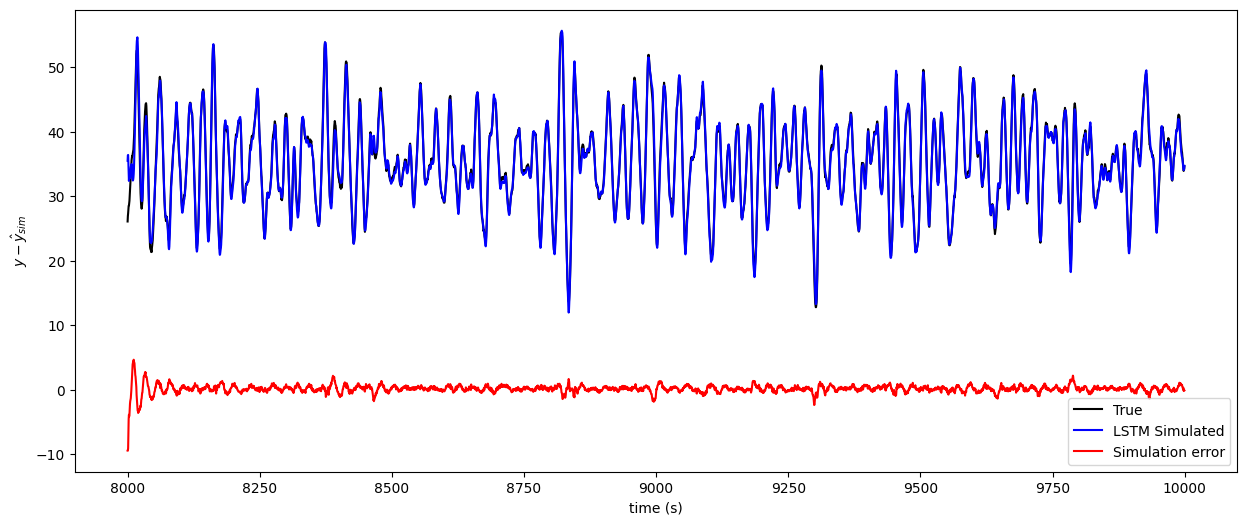

In [82]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6))

ax.plot(df_test["t"], df_test["y"], label="True", color="k")
ax.plot(df_test["t"], y_sim_test_lstm, label="LSTM Simulated", color="b", linestyle="-")
ax.set_ylabel(r"$y$")
ax.legend()

ax.plot(df_test["t"], df_test["y"].values - y_sim_test_lstm, label="Simulation error", color="r")
ax.set_ylabel(r"$y - \hat{y}_{sim}$")
ax.set_xlabel("time (s)")
ax.legend();

## Exercise

Familiarize with the code, experiment with different:
- number of hidden layers
- number of neurons
- optimizers
- learning rates
- epochs number.

## References

- [1] https://www.halvorsen.blog/documents/programming/python/resources/powerpoints/Mass-Spring-Damper%20System%20with%20Python.pdf

- [2] https://manojsrinivasan.org/Courses/ME8230NonlinearDynamics_Sp2016/LectureNotes/L14_ForcedNonlinearSystemsPhenomena.pdf

## Extra

A more sophisticated custom Dataset for sequences, with support for *partially* overlapping sequences

In [83]:
class SequenceDatasetOverlap(Dataset):
    r"""A dataset returning sub-sequences extracted from longer sequences.
        For simplicity, this version does not support overlapping subsequences.
    Args:
        *tensors (Tensor): tensors that have the same size on the first dimension.
        seq_len (int): length of the subsequences to extract.
        step (int): step size for extracting subsequences. Default is 1, meaning all possible overlapping subsequences are returned.
    Examples:
        >>> u = torch.randn(1000, 2) # 2 inputs
        >>> y = torch.randn(1000, 3) # 3 outputs
        >>> train_dataset = SequenceDataset(u, y, seq_len=100)
    """

    def __init__(self, *tensors, seq_len, step=1):
        self.tensors = tensors

        self.seq_len = seq_len
        assert all(tensor.shape[0] == self.tensors[0].shape[0] for tensor in self.tensors), "All tensors must have the same length"
        self.total_len = self.tensors[0].shape[0]
        self.step = step

    def __len__(self):
        return int(1 + (self.total_len - self.seq_len)//self.step)

    def __getitem__(self, idx):
        start = idx * self.step
        stop = start + self.seq_len
        return [tensor[start:stop] for tensor in self.tensors]

In [84]:
ds = SequenceDatasetOverlap(torch.arange(10), seq_len=3, step=2) # a single-seqence dataset
len(ds)

4

In [85]:
for i in range(len(ds)):
    print(ds[i])  # prints all sequences in the dataset with a step of 2

[tensor([0, 1, 2])]
[tensor([2, 3, 4])]
[tensor([4, 5, 6])]
[tensor([6, 7, 8])]


In [86]:
ds[4] # out of range

[tensor([8, 9])]

A more sophisticated RNN, with support for an initial state.

In [87]:
class RNN_H0(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(RNN, self).__init__()
        self.num_layers = num_layers
        self.hidden_size = hidden_size

        # RNN layer, implements the state-update equation f(x)
        self.seq = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)

        # Output layer, implements the linear output equation
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, u_seq, h0=None):
        
        # Initialize hidden state with zeros if not provided
        if h0 is None:
            if u_seq.ndim == 3:
                # If input is a batch of sequences, initialize h0 with batch size
                h0 = torch.zeros(self.num_layers, u_seq.size(0), self.hidden_size)
            elif u_seq.ndim == 2:
                h0 = torch.zeros(self.num_layers, self.hidden_size)
            else:
                raise ValueError("Input tensor must be 2D or 3D")

        # Run state-update sequentially for all time steps
        h, _ = self.seq(u_seq, h0) # hidden state sequence. 2nd return value is the last state, unused here.

        # Run output function
        y = self.fc(h) # output sequence
        return y